In [0]:
# This will be Team 18's Colab notebook for our project on classifying food groups in images
'''
importing necessary libraries
'''
import math
from shutil import copyfile
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # for plotting
import os
import sys

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# define the training, validation, and testing directories
train_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/food-11/training'
valid_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/food-11/validation'
test_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/food-11/evaluation'

#lucky's path
#train_path = '/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/food-11/training'
#valid_path = '//content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/food-11/validation'
#test_path = '/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/food-11/evaluation'

# the food categories in the dataset
classes = ['Bread', 'Dairy', 'VegetableFruit', 'Dessert', 'Egg', 'FriedFood', 'Meat', 'NoodlesPasta', 'Rice', 'Seafood', 'Soup']

# convert all jpgs to tensors
data_transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])

# load training, validation, and testing data
train_data = torchvision.datasets.ImageFolder(root = train_path, 
                                          transform=data_transform)

val_data = torchvision.datasets.ImageFolder(root = valid_path, 
                                          transform=data_transform)

test_data = torchvision.datasets.ImageFolder(root = test_path, 
                                          transform=data_transform)

print('Number of training images:', len(train_data))
print('Number of validation images:', len(val_data))
print('Number of testing images:', len(test_data))



Number of training images: 9866
Number of validation images: 3430
Number of testing images: 3352


In [0]:
def get_data_loader(batch_size):
    num_workers = 1
    np.random.seed(1000) 
    trainLoader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    valLoader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    testLoader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    return trainLoader, valLoader, testLoader

In [23]:
train_data.class_to_idx

{'0': 0,
 '1': 1,
 '10': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}

Number of training batches: 309
Number of validation batches: 108
Number of testing batches: 105


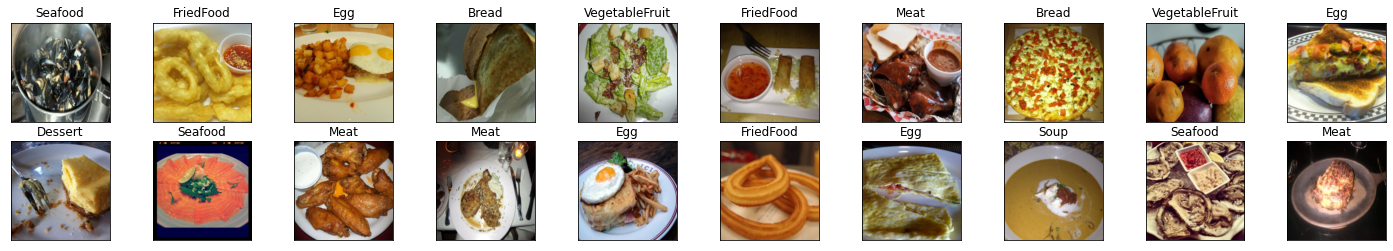

In [24]:
# obtain one batch of training images
train_loader, val_loader, test_loader = get_data_loader(32)

print('Number of training batches:', len(train_loader))
print('Number of validation batches:', len(val_loader))
print('Number of testing batches:', len(test_loader))

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [0]:
# turns classes into a mapping to int
mapping = {
classes[i] : i for i in range(len(classes))
}


'''
BASELINE MODEL-(K-NN)
'''

#probably should consider normalizing the rgb values so we don't risk overflowing

def getAccuracy(pred, labels):
    correct = (pred == labels.numpy().squeeze()).astype(int).sum()
    return correct/float(len(labels))

class baseline:   
    def __init__(self, data_loader):
        #centroids stored as average of RGB
        self.centroids = np.zeros((len(mapping), 3))
        self.calculateCentroids(data_loader)
    
    def calculateCentroids(self, data_loader):
        """
        data_loader with the following aspects:

        data: data set in the shape (# samples, 3 RGB, length, width)
        labels: labels for the data set in the shape (# samples)
        """
        #holds the number of pictures in each class
        count = np.zeros(len(mapping))

        #sum all of the rgb values
        for batch, (data, labels) in enumerate(data_loader):
            #FLATTEN
            data = data.view(data.shape[0], 3, -1)
            #calculate averages for RGB
            avgPixels = np.mean(data.numpy(), axis=2)
            for i, img in enumerate(avgPixels):
                label = labels[i].item()
                self.centroids[label] += avgPixels[i]
                count[label] += 1
            #so we don't spend too much time training
            if batch == 40:
                break

        #average the sum
        for i in range(len(self.centroids)):
            self.centroids[i] /= count[i]

    def forward(self, data):
        """
        data: data set in the shape (# samples, 3 RGB, length, width) 

        returns a list of classes that the model guesses (same as # samples)
        """
        data = data.view(data.shape[0], 3, -1)
        preds = []
        avgImgs = np.mean(data.numpy(), axis=2)
        for avg in avgImgs:
            #initialize to a large number so it gets overwritten
            minDist = sys.maxsize
            guessedLabel = 0
            #get how far the point is from the centroid of each cluster
            #choose the centroid that is closest and classify the point there
            for i, centre in enumerate(self.centroids):
                dist = np.linalg.norm(avg - centre)
                if dist < minDist:
                    minDist = dist
                    guessedLabel = i

            preds.append(guessedLabel)
        
        return preds          


In [0]:
baselineSucksMyAss = baseline(train_loader)

In [27]:
_, val_loader2, _ = get_data_loader(len(val_data.imgs))

for (imgs, labels) in val_loader2:
    preds = baselineSucksMyAss.forward(imgs)
    print(f'preds: {preds}')
    print(f'label: {labels.tolist()}')
    print(f'Accuracy: {getAccuracy(preds, labels)}')
    break

preds: [7, 6, 5, 7, 4, 6, 1, 9, 9, 1, 6, 6, 1, 6, 2, 1, 9, 1, 9, 2, 5, 1, 6, 6, 5, 9, 9, 1, 9, 2, 6, 2, 6, 6, 1, 7, 1, 0, 5, 1, 9, 3, 2, 6, 1, 1, 9, 9, 9, 6, 1, 2, 1, 5, 1, 1, 6, 1, 6, 6, 7, 1, 1, 6, 2, 1, 1, 5, 3, 0, 1, 6, 9, 1, 6, 6, 9, 6, 5, 6, 9, 10, 5, 6, 1, 1, 8, 5, 6, 9, 9, 1, 6, 6, 9, 9, 1, 6, 1, 0, 6, 6, 1, 1, 5, 5, 1, 6, 5, 2, 1, 6, 9, 2, 9, 1, 0, 6, 9, 6, 2, 1, 6, 5, 2, 6, 6, 2, 6, 3, 6, 5, 9, 9, 1, 2, 6, 9, 6, 1, 9, 6, 5, 5, 2, 5, 2, 9, 3, 6, 6, 9, 1, 6, 5, 3, 1, 9, 3, 1, 0, 5, 0, 9, 1, 1, 6, 1, 1, 5, 6, 8, 6, 6, 6, 8, 7, 9, 6, 5, 7, 9, 4, 8, 6, 2, 0, 1, 2, 6, 8, 1, 1, 3, 2, 2, 5, 1, 9, 6, 6, 3, 1, 6, 8, 1, 6, 1, 1, 10, 1, 1, 6, 8, 6, 6, 1, 1, 1, 9, 1, 1, 6, 0, 1, 2, 1, 1, 1, 1, 9, 6, 9, 6, 5, 9, 6, 5, 5, 5, 3, 2, 5, 3, 8, 6, 6, 1, 9, 5, 1, 9, 8, 1, 9, 1, 2, 9, 3, 10, 6, 1, 1, 5, 1, 1, 2, 5, 5, 1, 1, 1, 9, 6, 9, 5, 8, 1, 1, 5, 5, 6, 4, 3, 5, 6, 2, 9, 5, 2, 6, 6, 6, 1, 9, 9, 1, 2, 2, 6, 5, 3, 3, 9, 6, 1, 6, 6, 5, 6, 6, 6, 0, 3, 9, 6, 9, 2, 6, 1, 1, 1, 3, 5, 1, 9, 9, 9, 1, 6,

In [0]:
class restaurant(nn.Module):
    def __init__(self):
        super(restaurant, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(53*53*10, 32)
        self.fc2 = nn.Linear(32, 11)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 53*53*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
def get_accuracy(model, data, cuda=False):
    correct, total = 0, 0
    for pics, labels in data:
        if use_cuda and torch.cuda.is_available():
          pics = pics.cuda()
          labels = labels.cuda()
        output = model(pics)
        output = output.max(1, keepdim=True)[1]
        correct += output.eq(labels.view_as(output)).sum().item()
        total += labels.shape[0]
    return float(correct / total)

In [0]:
#pass in a data loader
def train_bot(model, train, valid, num_epochs=5, learning_rate=1e-5, plot=True, cuda=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_acc, train_loss, val_acc, val_loss = [], [], [], []
    start_time = time.clock()
    print('started the training at {}'.format(start_time))
    for epoch in range(num_epochs):
        #print("Epoch {}".format(epoch))
        for pics, labels in train:
            if use_cuda and torch.cuda.is_available():
              pics = pics.cuda()
              labels = labels.cuda()
            pred = model(pics)
            t_loss = criterion(pred.float(), labels)
            t_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        for pics, labels in valid:
            if use_cuda and torch.cuda.is_available():
              pics = pics.cuda()
              labels = labels.cuda()
            pred = model(pics)
            v_loss = criterion(pred, labels)
        val_loss.append(v_loss)
        train_loss.append(t_loss)
        train_acc.append(get_accuracy(model, train))
        val_acc.append(get_accuracy(model, valid))
    end_time = time.clock()
    diff = end_time - start_time
    print('ended the training at {}, time taken is {}'.format(end_time, diff))
    # plotting
    if plot == True:
      plt.title("Training Curve")
      plt.plot(range(num_epochs), train_loss, label="Train loss")
      plt.plot(range(num_epochs), val_loss, label="Valid loss")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend()
      plt.show()

      plt.title("Training Curve")
      plt.plot(range(num_epochs), train_acc, label="Train")
      plt.plot(range(num_epochs), val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend()
      plt.show()
    print('Most Recent Training Accuracy = ' + str(train_acc[num_epochs-1]))
    print('Most Recent Validation Accuracy = ' + str(val_acc[num_epochs-1]))
    print('Max Training Accuracy = ' + str(max(train_acc)))
    print('Max Validation Accuracy = ' + str(max(val_acc)))
    print('Most Recent Training Loss = ' + str(train_loss[num_epochs-1]))
    print('Most Recent Validation Loss = ' + str(val_loss[num_epochs-1]))
    print('Min Training Loss = ' + str(min(train_loss)))
    print('Min Validation Loss = ' + str(min(val_loss)))

In [0]:
# Data Loading
#@title old get_data_loader_for_smaller_dataset
def get_data_loader_for_smaller_dataset(master_path, batch_size, data_size, num_workers = 1):

  # Transform Settings - Do not use RandomResizedCrop
  transform = transforms.Compose([transforms.Resize((224,224)), 
                                  transforms.ToTensor()])
  train_ratio = 0.6
  val_ratio = 0.2
  test_ratio = 0.2
  num_cat = 11
  file_type = '.jpg'

  train_set_size_per_cat = math.ceil(train_ratio * data_size / num_cat)
  val_set_size_per_cat = math.ceil(val_ratio * data_size / num_cat)
  test_set_size_per_cat = math.ceil(test_ratio * data_size/ num_cat)

  # Goes through students and place them in Train/Validation/Test sets; Therefore no student would show up in 2 sets.
  for set_name in os.listdir(master_path):
    set_path = master_path + '/' + set_name
    for cat in os.listdir(set_path):
      cat_path = set_path + '/' + cat
      if set_name == 'training':
        for i in range(train_set_size_per_cat):
          source_path = cat_path + '/' + cat + '_' + str(i) + file_type
          dest_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/1000_set/train/' + cat + '/' + cat + '_' + str(i) + file_type
          copyfile(source_path, dest_path)
          #print('copied file: ' + source_path + ' to ' + dest_path)
      if set_name == 'validation':
        for i in range(val_set_size_per_cat):
          source_path = cat_path + '/' + cat + '_' + str(i) + file_type
          dest_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/1000_set/valid/' + cat + '/' + cat + '_' + str(i) + file_type
          copyfile(source_path, dest_path)
          #print('copied file: ' + source_path + ' to ' + dest_path)
      if set_name == 'evaluation':
        for i in range(test_set_size_per_cat):
          source_path = cat_path + '/' + cat + '_' + str(i) + file_type
          dest_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/1000_set/test/' + cat + '/' + cat + '_' + str(i) + file_type
          copyfile(source_path, dest_path)
          #print('copied file: ' + source_path + ' to ' + dest_path)
  
  #train_path = '/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/1000_set/train/'
  #valid_path = '/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/1000_set/valid/'
  #test_path = '/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/1000_set/test/'

  train_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/1000_set/test'
  valid_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/1000_set/train'
  test_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/1000_set/valid'

  trainset = torchvision.datasets.ImageFolder(root = train_path, 
                                            transform=transform)
  valset = torchvision.datasets.ImageFolder(root = valid_path, 
                                            transform=transform)
  testset = torchvision.datasets.ImageFolder(root = test_path, 
                                            transform=transform)
  print('Number of training images:', len(trainset))
  print('Number of validation images:', len(valset))
  print('Number of testing images:', len(testset))
  # Prepare Dataloader
  #Shuffles the data
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)

  val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)

  test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  print('Number of training batches:', len(train_loader))
  print('Number of validation batches:', len(val_loader))
  print('Number of testing batches:', len(test_loader))
  
  return train_loader, val_loader, test_loader

In [0]:
def get_data_loader_for_smaller_dataset(batch_size):
    num_workers = 1
    np.random.seed(1000) 

    small_train_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/1000_set/train'
    small_val_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/1000_set/valid'
    small_test_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/1000_set/test'

    data_transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])

    # load training, validation, and testing data
    train_data = torchvision.datasets.ImageFolder(root = small_train_path, 
                                            transform=data_transform)

    val_data = torchvision.datasets.ImageFolder(root = small_val_path, 
                                            transform=data_transform)

    test_data = torchvision.datasets.ImageFolder(root = small_test_path, 
                                            transform=data_transform)                                     

    trainLoader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    valLoader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    testLoader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    return trainLoader, valLoader, testLoader

Number of training images: 341
Number of validation images: 1023
Number of testing images: 341
Number of training batches: 11
Number of validation batches: 32
Number of testing batches: 11
CUDA is available!  Training on GPU ...
started the training at 10.81937
ended the training at 64.779441, time taken is 53.960071000000006


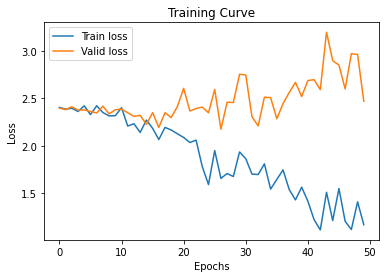

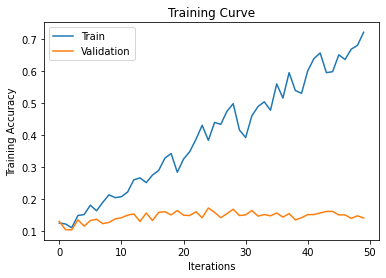

Most Recent Training Accuracy = 0.7214076246334311
Most Recent Validation Accuracy = 0.14173998044965788
Max Training Accuracy = 0.7214076246334311
Max Validation Accuracy = 0.17302052785923755
Most Recent Training Loss = tensor(1.1682, device='cuda:0', grad_fn=<NllLossBackward>)
Most Recent Validation Loss = tensor(2.4695, device='cuda:0', grad_fn=<NllLossBackward>)
Min Training Loss = tensor(1.1129, device='cuda:0', grad_fn=<NllLossBackward>)
Min Validation Loss = tensor(2.1754, device='cuda:0', grad_fn=<NllLossBackward>)


In [38]:
batch = 32
lr = 0.0001
epochs = 50
plot = True
data_size = 1700
use_cuda = True
master_path = '/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/food-11'
#print(os.listdir('/content/drive/My Drive/3rd year/2nd semester/aps360/APS360 Project/1000_set/test/3'))
train_loader, val_loader, test_loader = get_data_loader_for_smaller_dataset(batch)
#get_data_loader_for_smaller_dataset('/content/drive/My Drive/Colab Notebooks/APS360/APS360 Project/food-11', batch, data_size, num_workers = 1)
model = restaurant()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_bot(model, train_loader, val_loader, epochs, lr, plot, use_cuda)

In [39]:
print(get_accuracy(model, test_loader, use_cuda))

0.16129032258064516
